In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

# 1D Black-Scholes Model, Bermudan Put Option

Let $(S_t)_{t \in [0,T]}$ be a Black-Scholes process (geometric Brownian motion) with parameters $r$, $\sigma$, and fixed initial value $x_0 > 0$, that is,
$$
    S_t = x_0 e^{(r-\frac{\sigma^2}{2}) t + \sigma W_t}
$$
where $(W_t)_{t \in [0,T]}$ is a standard Brownian motion.

We consider fixed discrete times $t_n = n \frac{T}{N}$ for $n = 0, \dots, N$. The asset value at times $t_n$ forms a Markov chain denoted by $(X_n)_{n = 0,\dots,N}$, that is,
$$
    \forall n=0, \dots, N, \quad X_n = S_{t_n}
$$
The Bermudan put option is an option that can be exercised at any date $t_n$. If exercised at $t_n$, the associated payoff is
$$
    Z_n = \varphi(n, X_n) = e^{-r n \frac{T}{N}} (K - X_n)_+.
$$

We are thus interested in the discrete-time optimal stopping problem
$$
    V_0(x_0) = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ Z_\tau \big]
    = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ \varphi(\tau, X_\tau) \big],
$$
where $\mathcal{T}_0$ is the set of stopping times taking values in $\{0,\dots,N\}$.


In [2]:
r = 0.1
sigma = 0.25
x0 = 100
K = 110
N, T = 10, 1

In [3]:
def simu_BS1d(size_path, size_sample): 
    h = T/size_path
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(size_path, size_sample))
    sample = np.zeros(shape=(size_path+1, size_sample))
    sample[0] = x0
    for n in range(1, size_path+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [4]:
def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)

# Regression on a Function Basis

We consider $m$ functions $(e_k)_{1 \le k \le m}$ and the projection onto the subspace spanned by these functions, that is, the parametric function
$$
    \Phi(x; \theta) = \sum_{k=1}^m \theta_k e_k(x) \quad \text{with $\theta \in \mathbf{R}^m$}.
$$



In [5]:
def base1_ek(x): 
    return np.array([np.ones_like(x), x, x**2, x**3])

# same basis with the payoff (K - x)_+ added
def base2_ek(x): 
    return np.array([np.ones_like(x), np.maximum(K - x, 0), x, x**2, x**3])


In [6]:
base1_ek(0.2)

array([1.   , 0.2  , 0.04 , 0.008])

In [7]:
base1_ek(np.array([0.2, 0.5]))

array([[1.   , 1.   ],
       [0.2  , 0.5  ],
       [0.04 , 0.25 ],
       [0.008, 0.125]])

In [8]:
def theta_by_regression(payoff, x, ek=base1_ek):
    norm = (ek(x) @ ek(x).T)
    return np.linalg.inv(norm) @ (ek(x) @ payoff)

In [9]:
def function_Phi(x, theta, ek=base1_ek): 
    return np.dot(theta, ek(x))

# Longstaff-Schwartz Algorithm

We generate the set of scenarios: a sample of $M$ trajectories $(X^{(j)}_n)_{n=0,\dots,N}$ for $1 \le j \le M$, and the associated payoffs $(Z^{(j)}_n)_{n=0,\dots,N}$ for $1 \le j \le M$.


In [10]:
M = int(1e6)
sample_X = simu_BS1d(N, M)
payoffs_Z = np.empty_like(sample_X)
for n in range(0, N+1):
    payoffs_Z[n] = payoff_phi(n, sample_X[n])
    
print("Shape of sample_X: ", sample_X.shape)
print("Shape of payoffs_Z:", payoffs_Z.shape)

Shape of sample_X:  (11, 1000000)
Shape of payoffs_Z: (11, 1000000)


\begin{equation} \tag{$A_{LS}$}
\begin{cases}
    \tau^{(j)}_N = N, & \text{terminal condition} \\
    \tau^{(j)}_{n} = n \mathbf{1}_{Z^{(j)}_n \ge \Phi(X^{(j)}_n; \theta_n)} 
    + \tau^{(j)}_{n+1} \mathbf{1}_{Z^{(j)}_n < \Phi(X^{(j)}_n; \theta_n)}, & 1 \le n \le N-1
\end{cases}
\end{equation}


In [11]:
m = base1_ek(sample_X[0]).shape[0]   # retrieve the number of basis functions used
thetas = np.zeros((N, m))            # to store the "optimal" parameters

# tau_opt = N * np.ones(M, dtype=int)
payoff_opt = payoffs_Z[N].copy()

for n in reversed(range(1, N)):
    thetas[n] = theta_by_regression(payoff_opt, sample_X[n])
    stop_at_n = payoffs_Z[n] >= function_Phi(sample_X[n], thetas[n]) 
    # tau_opt[stop_at_n] = n 
    payoff_opt[stop_at_n] = payoffs_Z[n, stop_at_n].copy()


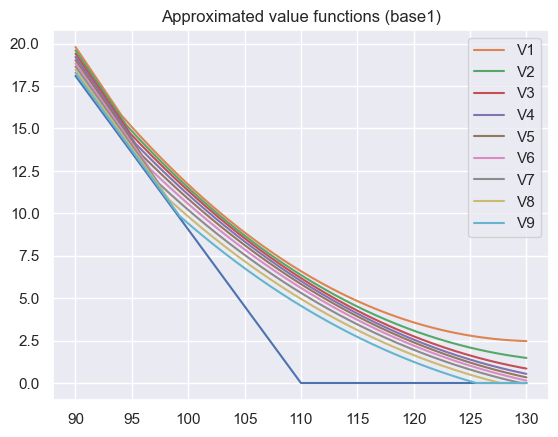

In [12]:
xx = np.linspace(90, 130, 1000)

fig, ax = plt.subplots()
ax.plot(xx, payoff_phi(N, xx))  # Terminal payoff at maturity

for n in range(1, N):
    ax.plot(
        xx,
        np.maximum(payoff_phi(n, xx), function_Phi(xx, thetas[n], base1_ek)),
        label=fr"V{n}"
    )

ax.legend()
ax.set_title("Approximated value functions (base1)")
plt.show()


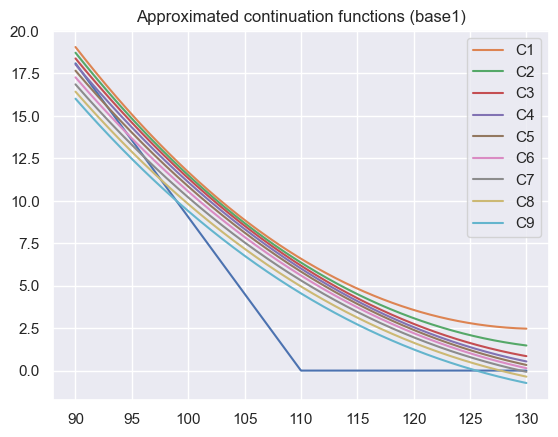

In [13]:
xx = np.linspace(90, 130, 1000)

fig, ax = plt.subplots()
ax.plot(xx, payoff_phi(N, xx))  # Terminal payoff at maturity

for n in range(1, N):
    ax.plot(xx, function_Phi(xx, thetas[n]), label=fr"C{n}")

ax.legend()
ax.set_title("Approximated continuation functions (base1)")
plt.show()


In [14]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)   
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result

In [15]:
monte_carlo(payoff_opt)

{'mean': np.float64(11.903322192211998),
 'var': np.float64(85.04583330578414),
 'lower': np.float64(11.885247345974317),
 'upper': np.float64(11.92139703844968)}

# Comparison of the Two Bases


In [16]:
bases = [ 
    { "name": "base1", "ek": base1_ek }, 
    { "name": "base2", "ek": base2_ek },
]

In [17]:
for base in bases:
    m = base["ek"](sample_X[0]).shape[0]      # retrieve the number of basis functions used
    thetas = np.zeros((N, m))                 # to store the "optimal" parameters

    tau_opt = N * np.ones(M, dtype=int)
    payoff_opt = payoffs_Z[N].copy()

    for n in reversed(range(1, N)):
        thetas[n] = theta_by_regression(payoff_opt, sample_X[n], base["ek"])
        stop_at_n = payoffs_Z[n] >= function_Phi(sample_X[n], thetas[n], base["ek"]) 
        tau_opt[stop_at_n] = n 
        payoff_opt[stop_at_n] = payoffs_Z[n, stop_at_n].copy()
    
    base["thetas"] = thetas
    base["payoff_opt"] = payoff_opt


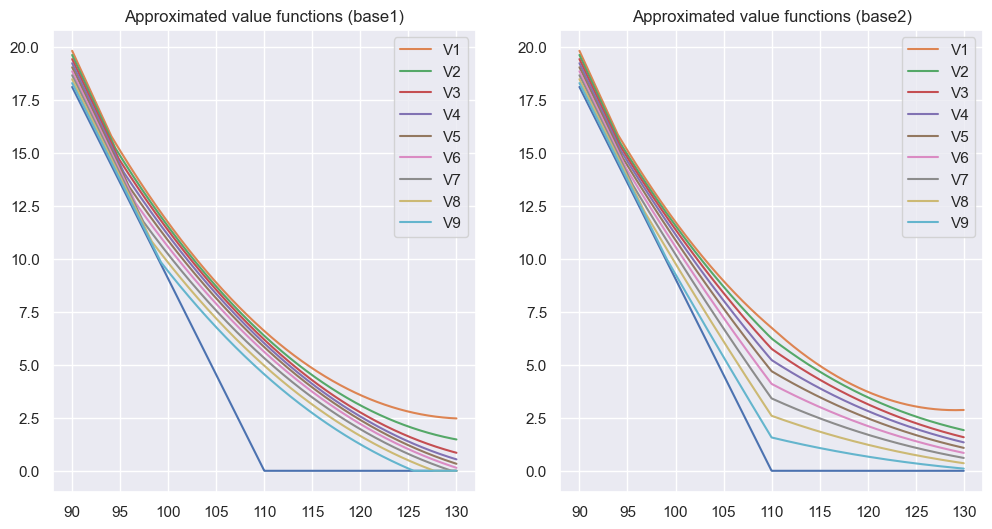

In [18]:
xx = np.linspace(90, 130, 1000)

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
for ax, base in zip(axs, bases): 
    ax.plot(xx, payoff_phi(N, xx))  # Terminal payoff

    for n in range(1, N):
        ax.plot(
            xx,
            np.maximum(payoff_phi(n, xx), function_Phi(xx, base["thetas"][n], base["ek"])),
            label=fr"V{n}"
        )
    
    ax.legend()
    name = base["name"]
    ax.set_title(f"Approximated value functions ({name})")

plt.show()


In [19]:
for base in bases: 
    print("Price with", base["name"]) 
    print(monte_carlo(base["payoff_opt"]))

Price with base1
{'mean': np.float64(11.903322192211998), 'var': np.float64(85.04583330578414), 'lower': np.float64(11.885247345974317), 'upper': np.float64(11.92139703844968)}
Price with base2
{'mean': np.float64(11.960228486310182), 'var': np.float64(88.25377966249609), 'lower': np.float64(11.941815902017257), 'upper': np.float64(11.978641070603107)}


# Resimulation

In [20]:
M = int(1e6)
sample_X = simu_BS1d(N, M)
payoffs_Z = np.empty_like(sample_X)
for n in range(0, N+1):
    payoffs_Z[n] = payoff_phi(n, sample_X[n])
    
print("Shape of sample_X: ", sample_X.shape)
print("Shape of payoffs_Z:", payoffs_Z.shape)

Shape of sample_X:  (11, 1000000)
Shape of payoffs_Z: (11, 1000000)


In [21]:
for base in bases:
    tau_opt = N * np.ones(M, dtype=int)
    payoff_opt = payoffs_Z[N].copy()
    thetas = base["thetas"]
    for n in reversed(range(1, N)):
        stop_at_n = payoffs_Z[n] >= function_Phi(sample_X[n], thetas[n], base["ek"]) 
        tau_opt[stop_at_n] = n 
        payoff_opt[stop_at_n] = payoffs_Z[n, stop_at_n].copy()

    base["payoff_opt"] = payoff_opt


In [22]:
for base in bases: 
    print("Price with", base["name"]) 
    print(monte_carlo(base["payoff_opt"]))

Price with base1
{'mean': np.float64(11.901797195355075), 'var': np.float64(85.2586842998897), 'lower': np.float64(11.883699744572034), 'upper': np.float64(11.919894646138115)}
Price with base2
{'mean': np.float64(11.957898021523137), 'var': np.float64(88.47969890489668), 'lower': np.float64(11.939461885273625), 'upper': np.float64(11.97633415777265)}
